# Load

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords

In [3]:
# import chardet
import codecs
with codecs.open('/kaggle/input/sms-spam-collection-dataset/spam.csv', 'r', encoding='ISO-8859-1') as f:
    df_raw = pd.read_csv(f)[['v1', 'v2']]
    
# df_raw = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding = result['encoding'])
df_raw.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Data Processing

## Preprocessing

In [4]:
rename_mapper = {'v1':'label',
                'v2':'txt'}
df_raw = df_raw.rename(columns = rename_mapper)
df_raw.head()

,label,txt
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df_raw.describe()

,label,txt
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df_raw.groupby(by = 'label').describe()

txt                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [7]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


def remove_punctuations(txt):
    import string
    return ''.join(w for w in txt if w not in string.punctuation)


def remove_shortwords(txt):
    return ' '.join(w for w in txt.split() if len(w)>=2)


def remove_stopwords(txt):
    txt =  ' '.join(w for w in txt.split() if w not in stopwords.words('english'))
    txt = ' '.join(w for w in txt.split() if w not in stopwords.words('spanish'))
    txt = ' '.join(w for w in txt.split() if w not in stopwords.words('french'))
    return txt


def stemmer(txt):
    stemmer = SnowballStemmer("english")
    return ' '.join(stemmer.stem(w) for w in txt.split())


def lemmatization(txt):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(w) for w in txt.split())
    
print(stemmer(remove_punctuations('Hello! This is Sarvenaz ... How is it going?, getting really hot hotty ')))

hello this is sarvenaz how is it go get realli hot hotti


In [8]:
print(stopwords.fileids()) # list of languages some of which are used in the stopwords function above

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [9]:
# df.sort_values(by = 'length', ascending = False)

In [10]:
df = df_raw.copy()
print(f'Before:\n {df.txt.iloc[2433]}')

df.txt = df.txt.apply(lambda txt: remove_punctuations(txt))
df.txt = df.txt.apply(lambda txt: remove_shortwords(txt))
df.txt = df.txt.apply(lambda txt: remove_stopwords(txt))
df.txt = df.txt.apply(lambda txt: stemmer(txt))

print(f'After:\n  {df.txt.iloc[2433]}')

Before:
 Indians r poor but India is not a poor country. Says one of the swiss bank directors. He says that \ &lt;#&gt;  lac crore\" of Indian money is deposited in swiss banks which can be used for 'taxless' budget for  &lt;#&gt;  yrs. Can give  &lt;#&gt;  crore jobs to all Indians. From any village to Delhi 4 lane roads. Forever free power suply to more than  &lt;#&gt;  social projects. Every citizen can get monthly  &lt;#&gt; /- for  &lt;#&gt;  yrs. No need of World Bank &amp; IMF loan. Think how our money is blocked by rich politicians. We have full rights against corrupt politicians. Itna forward karo ki pura INDIA padhe.g.m.\""
After:
  indian poor india poor countri say one swiss bank director he say ltgt lac crore indian money deposit swiss bank use taxless budget ltgt yrs can give ltgt crore job indian from villag delhi lane road forev free power supli ltgt social project everi citizen get month ltgt ltgt yrs no need world bank amp imf loan think money block rich politician we

In [11]:
from nltk.tokenize import word_tokenize
# since we are do countvectorizer later in this notebook, I removed tokenization from this step
df_t = df.copy()
# df_t.txt = df_t.txt.apply(lambda txt: word_tokenize(txt))


# Feature Creation

In [12]:
# new feature: length of the messages
df['length'] = df.txt.apply(lambda sms: len(sms))
df_t['length'] =  df['length']

Let's see if message length is a reasonable feature to add:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='length', ylabel='Count'>

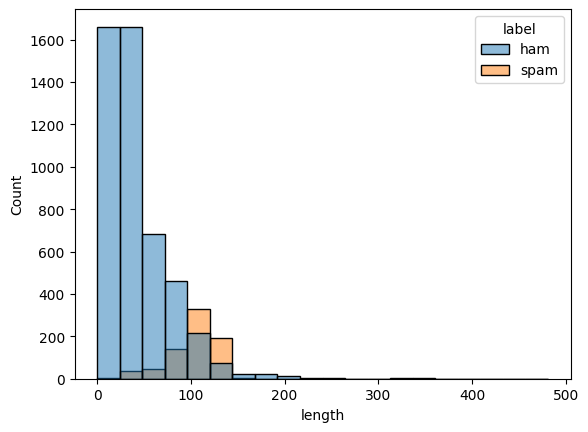

In [13]:
sns.histplot(data = df, x = 'length', hue = 'label', bins = 20)

There's a good chance that shorter messages are not spam. So I will keep the feature.

<Axes: xlabel='label', ylabel='count'>

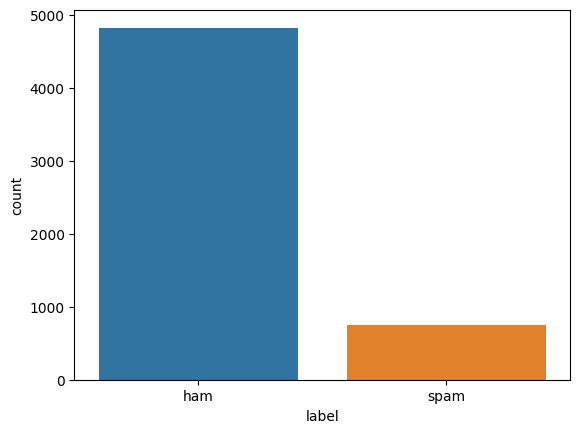

In [14]:
import seaborn as sns
sns.countplot(data = df, x ='label')

The data is a highly skewed one! I will take care of it later through:
1- over sampling
2- weight assignment during training

In [15]:
df_t.label = df_t.label.map({'ham':0, 'spam':1})
df_t

,label,txt,length
0,0,go jurong point crazi avail bugi great world b...,69
1,0,ok lar joke wif oni,19
2,1,free entri wkli comp win fa cup final tkts 21s...,130
3,0,dun say earli hor alreadi say,29
4,0,nah dont think goe usf live around though,41
...,...,...,...
5567,1,this 2nd time tri contact å£750 pound prize cl...,108
5568,0,will go esplanad fr home,24
5569,0,piti mood soani suggest,23
5570,0,the guy bitch act like id interest buy someth ...,72


In [16]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(df_t[['txt', 'length']], df_t.label, random_state = 42)
xtrain = xtrain.reset_index(drop = True)
xval = xval.reset_index(drop = True)
ytrain = ytrain.reset_index(drop = True)
yval = yval.reset_index(drop = True)

## Count Vectorizer

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

xtrain_v = vectorizer.fit_transform(xtrain['txt'])
xval_v = vectorizer.transform(xval['txt'])

## TFid Transformer

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
tfid = TfidfTransformer()

xtrain_tf = tfid.fit_transform(xtrain_v)
xval_tf = tfid.transform(xval_v)

In [19]:
xtrain_tf = pd.DataFrame(xtrain_tf.toarray(), columns = vectorizer.get_feature_names_out())
xval_tf = pd.DataFrame(xval_tf.toarray(), columns = vectorizer.get_feature_names_out())

In [20]:
xval.tail()

,txt,length
1388,have good even ttyl,19
1389,take exam march,15
1390,aiyah ok wat long got improv alreadi wat,40
1391,sif one good partnership go take lead,37
1392,get messag,10


# Model

### Dummy classifier: 
classify everything as the majority class

In [21]:
dummy_pred = np.zeros(1393,)
print(classification_report(dummy_pred, yval))
print('---------------------------------------')
print(confusion_matrix(dummy_pred, yval, normalize = 'true')*100)

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93      1393
         1.0       0.00      0.00      0.00         0

    accuracy                           0.86      1393
   macro avg       0.50      0.43      0.46      1393
weighted avg       1.00      0.86      0.93      1393

---------------------------------------
[[86.28858579 13.71141421]
 [ 0.          0.        ]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight = 'balanced')

Let's see what we'll get from the model by running it on the data as is:

#### On vectorized data

In [23]:
lrc = LogisticRegression()
lrc.fit(xtrain_v, ytrain)
predict = lrc.predict(xval_v)
from sklearn.metrics import classification_report, confusion_matrix
print('----------- Count Vectorizer-------------------------')
print(classification_report(predict, yval))
print('-----------------------------------------------------')
print(np.trunc(confusion_matrix(predict, yval, normalize = 'true')*100))

----------- Count Vectorizer-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1227
           1       0.86      0.99      0.92       166

    accuracy                           0.98      1393
   macro avg       0.93      0.98      0.95      1393
weighted avg       0.98      0.98      0.98      1393

-----------------------------------------------------
[[97.  2.]
 [ 1. 98.]]


#### on tfid data

In [24]:
lrtf = LogisticRegression()

In [25]:
lrtf = LogisticRegression(class_weight = 'balanced')
lrtf.fit(xtrain_tf, ytrain)
pred = lrtf.predict(xval_tf)
print('----------- TFID -------------------')
print(classification_report(pred, yval))
print('---------------------------------------')
print(np.trunc(confusion_matrix(pred, yval, normalize = 'true')*100))

----------- TFID -------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1207
           1       0.90      0.92      0.91       186

    accuracy                           0.98      1393
   macro avg       0.94      0.95      0.95      1393
weighted avg       0.98      0.98      0.98      1393

---------------------------------------
[[98.  1.]
 [ 7. 92.]]


It is odd for me that countvectorizer is doing better than tfid. I did a quick research:

from: https://datascience.stackexchange.com/questions/49047/will-a-count-vectorizer-ever-perform-slightly-better-than-tf-idf
As the size of the vocabulary increases, TfidfVectorizer would be better able to differentiate rare words and commonly occurring words while Countvectorizer would still give equal weight to all words which is undesirable. So, TfidfVectorizer will give you better performance than CountVectorizer as the size of the vocabulary increases.


from: https://datascience.stackexchange.com/questions/12607/tf-idf-vectorizer-doesnt-work-better-than-countvectorizer
There are a few possibilities. First, there is some variability in performance. It could have been only by chance that countvectorizer performed better than tf-idf. Did you use cross validation (with how many folds)? Is the superior performance of the countvectorizer reliable? I would compare performance across folds to make sure countvectorizer consistently performs better.

Second, if you find that countvectorizer reliably outperforms tf-idf on your dataset, then I would dig deeper into the words that are driving this effect. It may be that common words (words which will appear in multiple documents) are helpful in distinguishing between classes. There is substantial research that shows that use of some function words (e.g. first person singular pronouns, “I”) change depending on someone’s psychological state. Function words like pronouns are very common and would be down weighted in tf-idf, but given equal weight to rare words in countvectorizer. I’m not suggesting that first person singular pronouns in particular are driving your results, but it’s worth looking at what words are driving the effect. I would examine which words are important in both types of models, countvectorizer and tf-idf, and then think about whether the words that are most important for the countvectorizer make sense in the context of your text documents and labels. Also, are you removing stop words? You could also see how the models perform with and without stop words, which would be another way to test whether frequent words are actually helping you to distinguish between classes.

Lets take a look at some of the false positive ones (ham, but classifed as spam)

In [26]:
xval_tf.head()

,008704050406,0089mi,0121,0125698789,02,020603,0207,02070836089,02072069400,02073162414,...,ìï,ìïll,ûthank,ûªm,ûªt,ûªv,ûï,ûïharri,ûò,ûówel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
xval[yval < pred]

,txt,length
100,like new mobil,14
101,now free call pa,16
179,yup next stop,13
209,send new number,15
299,new address applespairsal malarki,33
547,yes chat,8
567,when get free call,18
765,send ur birthdat month year tel ur life partne...,77
786,we sent jd custom servic cum account execut ur...,76
974,call right call hand phone,26


In [28]:
lrtf.predict_proba(xval_tf)[[100, 101, 567, 1188]]

array([[0.12698194, 0.87301806],
       [0.1013516 , 0.8986484 ],
       [0.15393372, 0.84606628],
       [0.19907661, 0.80092339]])

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(yval, pred)

0.9444381528168584

In [30]:
# # Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()

# nb.fit(xtrain_tf, ytrain)
# pred = nb.predict(xval_tf)
# print('----------- TFID -------------------')
# print(classification_report(pred, yval))
# print('---------------------------------------')
# print(np.trunc(confusion_matrix(pred, yval, normalize = 'true')*100))

It is doing a great job as is. But we dont want it to classify any ham msg as spam. So need to reduce the FP ones.